In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Resources

**Books (on Google Drive):**

Introduction to Statistical Learning, chapters 4.1 and 4.2

Hands on Machine Learning with scikit-learn and tensorflow, chapter 2


**Scikit-learn doc:**

https://scikit-learn.org/stable/

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

https://scikit-learn.org/stable/modules/cross_validation.html


**Other resources:**

https://www.youtube.com/watch?v=UqYde-LULfs

https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb

# Classification with scikit-learn : predicting heart diseases with machine learning

## The Heart disease dataset

For discovering classification, we're gonna use a rather classic dataset: the heart disease dataset. This dataset contains 13 symptoms and other attributes of patients that have been checked for a heart disease, such as their age, their cholesterol blood level, the type of pain they report, .... observed on 303 patients. These 13 attributes are called the *features*. And for each of these patients, we know if they have a heart disease or not: the field called *target* in the dataset. This field is generally called the *classes* of the problem, in this case we have two classes : 0 for healthy patients, and 1 for patients with a heart disease, hence it is called a *binary classification problem*.

As with linear regression, we generally denote the feature matrix by $X$, and the classes with $y$, where, in this dataset:


$$X \in \mathbb{R}^{303 \times 13}, y \in  \{0,1\}^{303}.$$
The goal of classification is to learn a function, or *classifier*, $f$ that approximates the true classes $y$ from the features $X$:


$$y \approx f(X).$$

However as $y$ is categorical in classification problems since it represents different classes, as opposed to a continuous value as in linear regression, we cannot use linear regression for solving these problems, and we need different models. 

Also note that classification is not always binary, and can classify features between more than 2 classes (will not be covered today, but the models that we will use here can be directly used with any number of classes).

To get a better idea of these concepts, read chapter 4.1 and 4.2 from the *Introduction to Statistical Learning* book.

First, let's load the dataset into a pandas DataFrame:

In [43]:
dataset = pd.read_csv('../data/heart.csv')

Let's have a look at the column and content:

In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Here are the 13 features, and the classes assignation column called here *target*. We can see that there is no missing values in the data, so far so good. Their names correspond to the following clinical observations:

|Name |Type |	Description |
|-----|-----|---------------|
|age      |integer | age of patient |
|sex      |integer | 1=male; 0=female |
|cp       |integer | chest pain type: 0=typical angina; 1=atypical angine; 2=non-anginal pain; 3=asymptomatic |
|trestbps |integer | resting blood pressure (mm Hg) |
|chol     |integer | serum cholestrol (mg/dl) |
|fbs      |integer | fasting blood sugar: 1 if > 120 mg/dl; 0 otherwise |
|restecg  |integer | resting electrocardiographic results: 0=normal; 1=having ST-T wave abnormality; 2=showing probable or definite left ventricular hypertrophy |
|thalach  |integer | maximum heart rate achieved |
|exang    |integer | exercise induced angina: 1=yes; 0=no |
|oldpeak  |float   | ST depression induced by exercise relative to rest |
|slope    |integer | the slope of the peak exercise ST segment: 0=upsloping; 1=flat; 2=downsloping |
|ca       |integer | number of major vessels (0-4) colored by flourosopy |
|thal     |integer | 1=normal; 2=fixed defect; 3=reversable defect |
|target      |integer | predicted attribute; 0=NO HEART DISEASE; 1=HEART DISEASE |

Some of these features have continuous values such as *age* or *chol*, while others are categorical such as *cp* or *slope*. We will see that categorical variables need to be handled differently when preprocessing the data.

This dataset is derived from : https://archive.ics.uci.edu/ml/datasets/Heart+Disease

## Getting into the data

Let's now have a look of the distribution of the values of each columns:

In [45]:
dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.326733,0.455446
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.583020,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,0.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


We can see that the distribution of the features are different: the age vary from 29 to 77, whereas cholesterol rates from 126 to 564. To avoid some features to bias the classifier because they have larger values than others, we will need to center their means to 0 and scale their variance to 1 when preprocessing them.
Let's now plot the histogram of each feature :

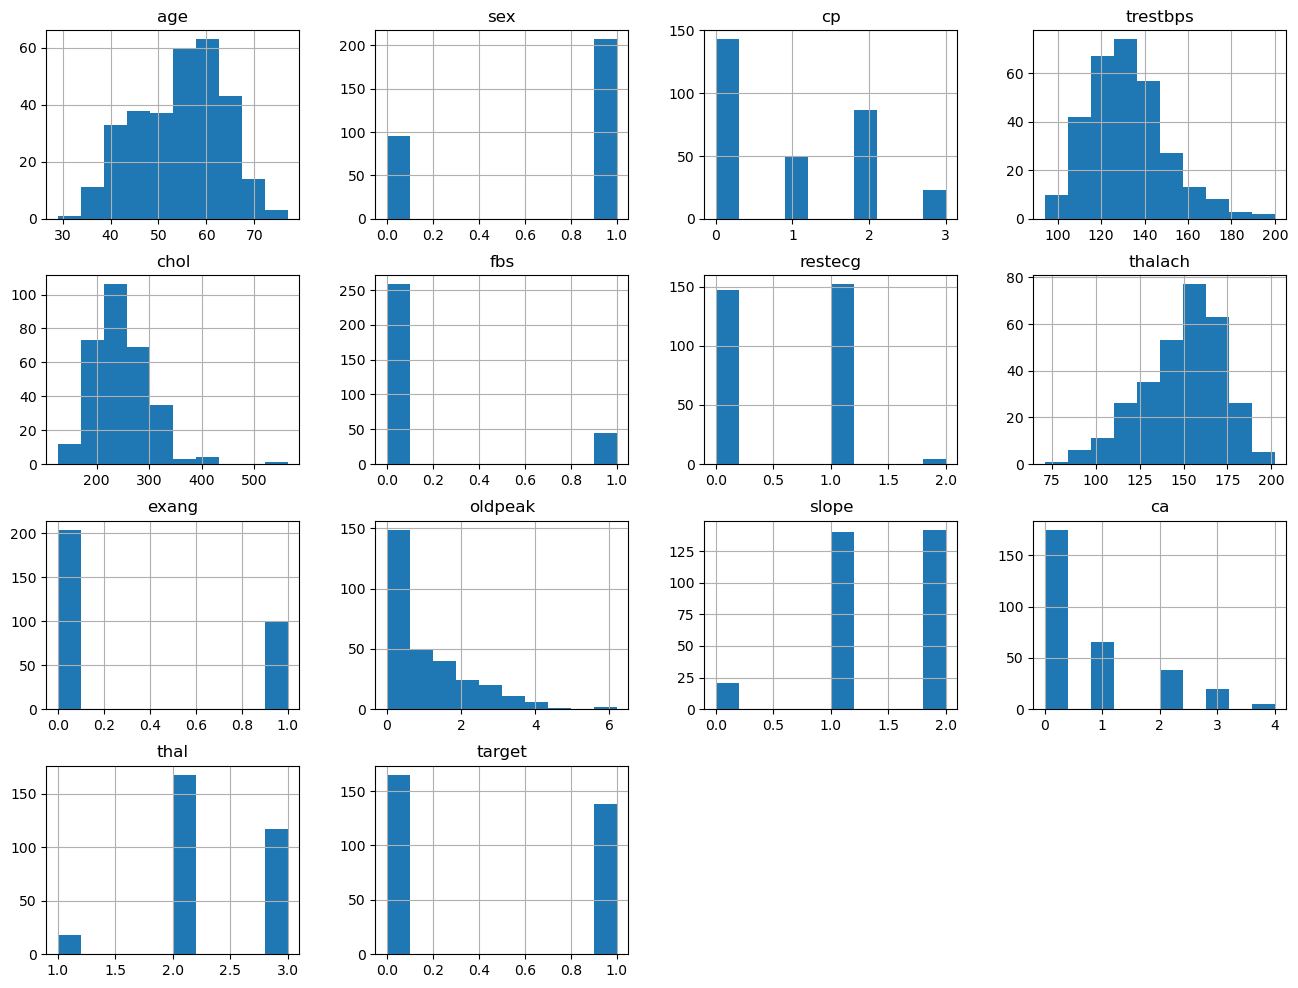

In [46]:
rcParams['figure.figsize'] = 16,12
plots = dataset.hist()

It is quite clear now that some of the features are categorical with peaks only at some value, whereas others are continuous.

Another important thing to check when performing classification is the balance between the target classes: is there as many samples (=patients) that are sick as there are healthy patient:

Text(0.5, 1.0, 'Count of each Target Class')

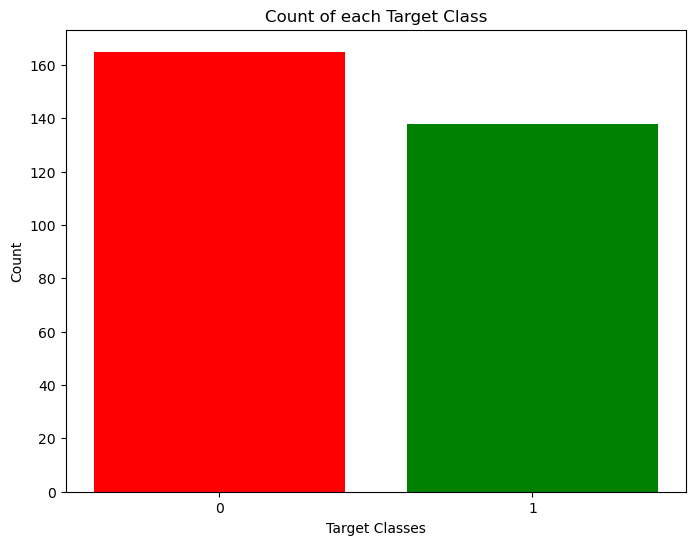

In [47]:
rcParams['figure.figsize'] = 8,6
plt.bar(dataset['target'].unique(), dataset['target'].value_counts(), color = ['red', 'green'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class')

A too much imbalanced dataset can bias the classification model towards the class with more samples. Here we see that the two classes, healthy and having a heart diseased, are quite balanced in this dataset. (Some classification models allow for correcting this if needed, you can later have a look at : https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html , but we won't need it today).

We can also plot the correlation matrix beween all the features and the target classes to get an idea of which features will probably be good predictors for our problem :

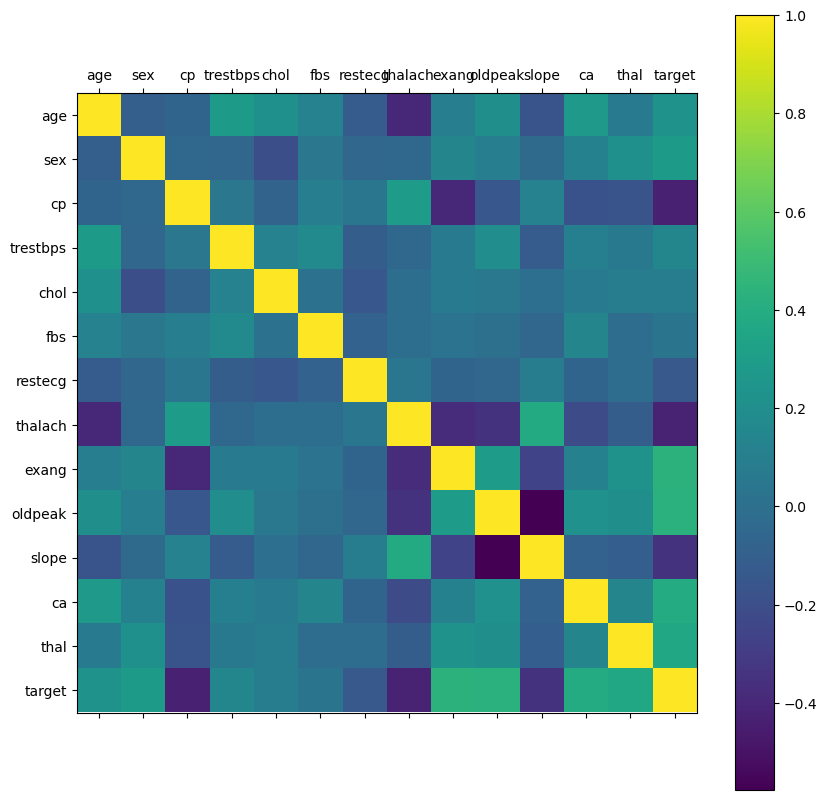

In [48]:
#Some correlate with target, others not
rcParams['figure.figsize'] = 14, 10
plt.matshow(dataset.corr())
plt.yticks(np.arange(dataset.shape[1]), dataset.columns)
plt.xticks(np.arange(dataset.shape[1]), dataset.columns)
plt.colorbar()

Here we can see that no single feature has a very high or very low correlation with the target value, meaning that the diagnostic is complex and will require a combination of all of these.

## Preprocessing data

We have seen that we have categorical features, for example the *cp* feature that describes the chest pain type reported with number from 0 to 3:
0=typical angina; 1=atypical angina; 2=non-anginal pain; 3=asymptomatic.

However these are *qualitative* categories, and there is no notion of distance between these numbers: an atypical angina is not 2 times a typical angina! 

To handle that we are going to create what we call *dummy variables*, that is, for each value 0, 1, 2, and 3, we are going to create a new feature which is a 0-1 feature only, and has a 1 value only for its own value. However we will do that only for *multicategorical* features : the ones that have more than two distinct values, since binary features like *sex*, *exang* and *fbs* are already 0-1 features.

In [49]:
multicategorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal']  
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
other_features =['sex','fbs','exang']

To create dummy variables, have a look at the get_dummies function from pandas.

In Pandas, the get_dummies() function converts categorical variables into dummy/indicator variables (known as one-hot encoding). This method is especially useful when preparing data for machine learning algorithms that require numeric input.

In [50]:
#TOFILL
dataset = pd.get_dummies(dataset, columns=multicategorical_features, dtype=int)
print('\n DataFrame after performing One-hot Encoding')
display(dataset)


 DataFrame after performing One-hot Encoding


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,...,0,0,1,0,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,...,0,0,1,0,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,0,...,0,1,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,0,0,...,0,1,1,0,0,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,1,1,...,1,0,1,0,0,0,0,0,0,1
299,45,1,110,264,0,132,0,1.2,1,0,...,1,0,1,0,0,0,0,0,0,1
300,68,1,144,193,1,141,0,3.4,1,1,...,1,0,0,0,1,0,0,0,0,1
301,57,1,130,131,0,115,1,1.2,1,1,...,1,0,0,1,0,0,0,0,0,1


Let's now plot our new features to see the difference:

In [51]:
rcParams['figure.figsize'] = 16,12
plots = dataset[multicategorical_features].hist()

KeyError: "None of [Index(['cp', 'restecg', 'slope', 'ca', 'thal'], dtype='object')] are in the [columns]"

Let's now separate the features from the classes in an $X$ and $y$ variables:

In [ ]:
#TO FILL
#Separate features and target 
y = dataset["target"]
X = dataset.drop("target", axis=1)

We've also said that we should center and scale our continuous variables to avoid biasing the classification model, use the *StandardScaler* class from scikit-learn to do so, after splitting the data set between train and test, to fit the scaler on the train set only :

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Split with a 30% test set, we stratify so that we have the same rate of positives
#in the training and test sets (as well as the same sex ratio, it will be useful at the end of the notebook)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 41, 
                                                    test_size = 0.3, 
                                                    stratify = pd.concat([dataset['sex'], y], axis = 1))

#Scaling continuous variables
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test_scaled = X_test.copy()
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])

Fill the memo.txt file to answer the following question: => cf mémo

1) What are the necessary preprocessing steps regarding:

a) classes:

Les classes dans la varible cible => variable à prédire. 
La variable target correspond dans ce jeu de données à la présence ou non d’une maladie du cœur.
C’est une variable binaire, qui est codée en 0 = pas de maladie du cœur et 1 = maladie cœur.
y = dataset["target"]  
X = dataset.drop("target") (toutes les autres colonnes)   
Cela permet de séparer clairement la cible (y) des variables explicatives (X).

Il est important de vérifier l’équilibre des classes : si une classe est beaucoup plus représentée que l’autre, le modèle risque d’être biaisé.
C’est pour cela qu’on utilise stratify=y dans le train_test_split pour garder la même proportion de classes dans le train et le test.
Quand on fait un train_test_split, on veut que la proportion de patients malades / non malades (la variable target, y) soient les mêmes dans le jeu d’entraînement et dans le jeu de test.
Ici on veut également 30 % du jeu de données dans le jeu test (70 % dans le jeu d’entraînement). On indiquera donc test_size = 0.3.
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state = 42, 
                                                    test_size = 0.3,stratify = y)

Cela garantit que la proportion de 0 et 1 dans y (malades / pas malades) est la même dans les deux sous-ensembles. Mais ça ne garantit rien pour les autres variables, par exemple le sexe.
Dans le jeu de données actuel, on veut également que la proportion soit identique entre les hommes et les femmes que dans le jeu de départ : on va donc prendre dans la stratify la variable sexe en plus : 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, 
                                                    test_size = 0.3, 
                                                    stratify = pd.concat([dataset['sex'], y], axis = 1)) 

La stratification ne se fait pas seulement sur la classe de la cible, mais sur toutes les combinaisons possibles de sexe + target 
Sexe	Target	Interprétation
0	0	Femme sans maladie
0	1	Femme avec maladie
1	0	Homme sans maladie
1	1	Homme avec maladie

Le split aura le même ratio d’hommes/femmes et de malades/sains dans chaque sous-ensemble que dans la base de données de daprt.
Si on ne contrôle pas le ratio du sexe dès le split, il se peut que le test contienne beaucoup plus d’hommes que de femmes (ou inversement) par rapport au jeu de données, ce qui fausserait les comparaisons.


b) categorical features ? 

On va regrouper les colonnes qui contiennent des valeurs qualitatives avec plusiuers modalités
multicategorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal']      
Les modèles de machine learning ne peuvent pas lire du texte ou des catégories telles quelles, donc il faut les encoder.
Pour cela, on utilise en général un One-Hot Encoding, via pd.get_dummies() :
      df_encoded = pd.get_dummies(dataset[multicategorical_features], dtype=int, drop_first=False)
Chaque modalité d’une variable devient une colonne binaire (0/1).
On fait cet encodage avant de faire le split train/test, pour s’assurer que les deux jeux aient les mêmes colonnes.


c) continuous features ?

Ce sont les variables numériques  ici :
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

Ces variables n’ont pas toutes la même échelle (âge en années, cholestérol en mg/dL, etc.).
Il faut donc les standardiser pour que le modèle ne soit pas influencé par les différences d’échelle. On va donc utiliser la fonction StandardScaler() de Scikit-Learn :
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[continuous_features])
X_test_num = scaler.transform(X_test[continuous_features])

⚠️ Comme évoquer lors de la régression linéaire : on fit transform le scaler uniquement sur le train et on transforme seulement le test.

## Classification with k-nearest neighbors, and classification metrics

One easy introduction to classification is to start with the k-neareast neighbors method (KNN). At training, it simply memorizes all the training samples features $X$ and classes $y$. At test time given the features of one sample $x'$, it identifies the $k$ training samples $x_i, i \in 1,\dots,k$ that are the closest to $x'$ (in euclidian distance), and assign the class $y'$ that is the most frequent among the k-neareast neighbor classes $y_i, i \in 1,\dots,k$.

So each test sample is assigned a probablity, for example of having a heart disease:


$$P(y' = 1 ) = \frac{1}{k} \sum_{ i \in 1,\dots,k} \mathbb{1}(y_i = 1) $$
    
where the indicator function $\mathbb{1}(y_i = 1) = 1$ if $y_i = 1$, else $\mathbb{1}(y_i = 1) = 0$. So the probability of having a heart disease is the proportion of the k-nearest train samples that have a heart disease.

For an intuitive explanation of KNNs, watch the first 1:45min of this vid (the rest of it that is about Voronoi partitions is not necessary): https://www.youtube.com/watch?v=UqYde-LULfs

You can also read pages 38-40 from the *Introduction to Statistical Learning*.

Compute the predictions of a k-nearest neighbors classifier on the test set, with k=15 :

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 15

#TOFILL: 
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train_scaled, y_train)

y_test_pred = knn.predict(X_test_scaled)

Use these predictions to compute the accuracy of your 15-nearest neighbors model :

In [ ]:
from sklearn.metrics import accuracy_score

#TOFILL
accu_score=accuracy_score(y_test, y_test_pred)
print("Accuracy:", accu_score)

Accuracy: 0.8131868131868132


$\approx$ 81%, pretty good for someone who doesn't know about medicine ! However accuracy is a quite limited view of the prediction abilities of your classifier. Indeed it doesn't make the difference between patients that have been incorrectly classified with a heart disease (because they were healthy) with patients that have been incorrectly classified as healthy (because they had a disease).

Let's look at the *confusion matrix* of the prediction, it gives use the number of patients that have been correctly classified as having a disease : the *true positives* (TP) ; the number of patients that have been correctly classified as not having a disease : the *true negatives* (TN); the number of patients that have been incorrectly classified as having a disease : the *false positives* (FP) ; and the number of patients that have been incorrectly classified as nothaving a disease : the *false negatives* (FN). To remember more easily, remark that the true/false refers to the *true* class of the test samples, whereas the positive/negative refers to the *predicted* class by the classifier.

The confusion matrix gives these four numbers in the following format:

|  |  |
|--|--|
|TN|FP|
|FN|TP|

The accuracy is computed by :


$$accuracy= \frac{TP + TN}{TP + TN + FP + FN}$$

One can also look at the accuracy of positive predictions, called the *precision*:


$$precision= \frac{TP }{TP + FP}$$

Or at the ratio of positive samples correctly detected by the classifier, called the *recall*:


$$recall= \frac{TP }{TP + FN}$$
     

These two metrics are often grouped together as a single one called the *f1-measure*:

$$F1=  2 \times \frac{precision \times recall}{precision + recall}$$

You can read more about it in chapter 3 of the book *Hands on Machine Learning with scikit-learn and tensorflow*.

So these metrics gives use different informations about our classifier predictive performances, we are gonna see in more details how below, first compute them on the results of your predictions :

Matrice de confusion :
        Prédit 0  Prédit 1
Vrai 0        45         5
Vrai 1        12        29


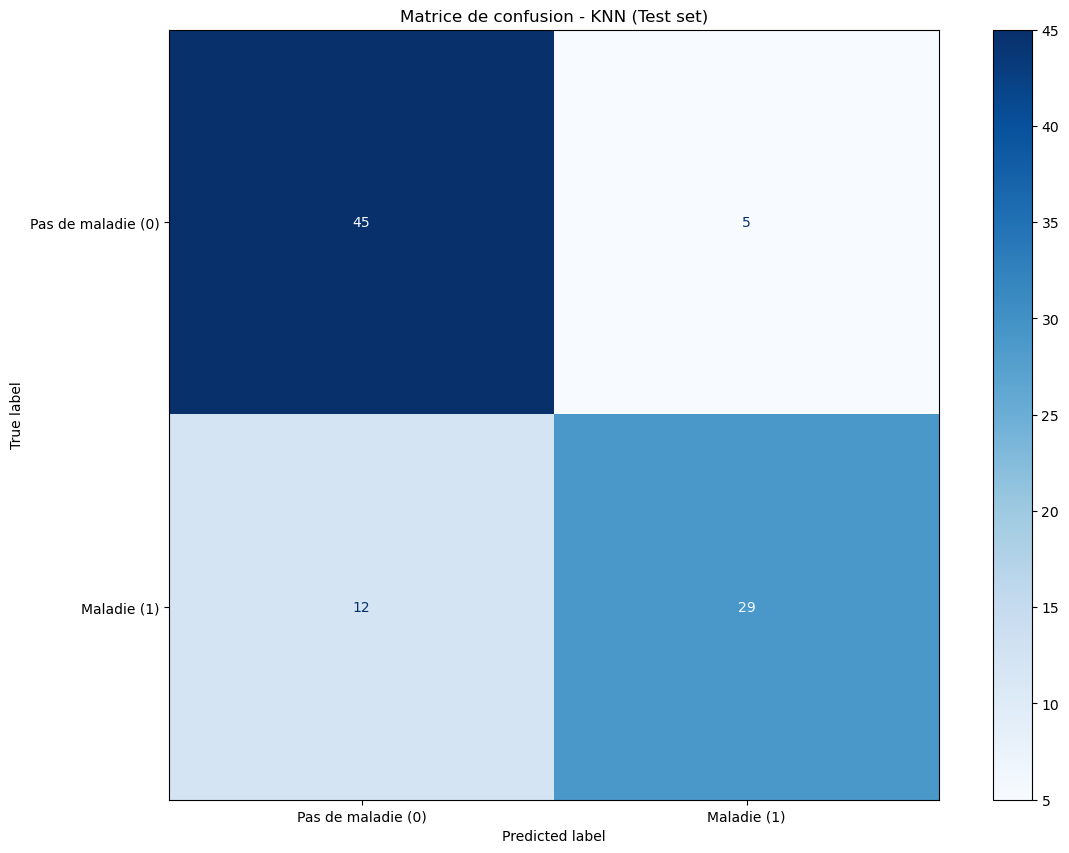

=== Évaluation du KNN with k=15 ===
Accuracy : 0.8132
Precision: 0.8529
Recall   : 0.7073
F1-score : 0.7733
----------------------------------------

Classification report :
              precision    recall  f1-score   support

           0      0.789     0.900     0.841        50
           1      0.853     0.707     0.773        41

    accuracy                          0.813        91
   macro avg      0.821     0.804     0.807        91
weighted avg      0.818     0.813     0.811        91


Matrice de confusion normalisée (par ligne) :
        Prédit 0  Prédit 1
Vrai 0     0.900     0.100
Vrai 1     0.293     0.707


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score, classification_report
#TOFILL

# Matrice de confusion (brute)
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=["Vrai 0", "Vrai 1"], columns=["Prédit 0", "Prédit 1"])
print("Matrice de confusion :")
print(cm_df)

# 2️⃣ Affichage graphique
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas de maladie (0)", "Maladie (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion - KNN (Test set)")
plt.show()


def eval_model(y_true, y_pred, model_name="Modèle"):
    """
    Affiche les principales métriques de classification :
    Accuracy, Précision, Recall et F1-score.
    """
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    
    print(f"=== Évaluation du {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("-" * 40)
    
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

eval_model(y_test, y_test_pred, model_name="KNN with k=15")
# Métriques principales

# (optionnel) Rapport détaillé
print("\nClassification report :")
print(classification_report(y_test, y_test_pred, digits=3))


# Astuce : si tu veux la matrice de confusion normalisée (en pourcentages par ligne) :
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm_df = pd.DataFrame(cm_norm, index=["Vrai 0", "Vrai 1"], columns=["Prédit 0", "Prédit 1"])
print("\nMatrice de confusion normalisée (par ligne) :")
print(cm_norm_df.round(3))

Fill the memo.txt file to answer these questions:

2)a) How many patient were incorrectly diagnosed with a Heart disease ?   
Ici on va regarder les Faux Positifs (FP) c'est à dire les patients sains mais prédit comme malades. 
FP = 5

2)b) How many patient were incorrectly diagnosed as being Healthy ?    
On va regarder les faux négatifs (FN) c'est à dire les patients malades, mais prédits comme sains.
FN = 12 


In general, remember that accuracy is more sensitive to class imbalance (which is not the case here as there is roughly as many positive as negative samples in the data), and that the f1 better summarizes balance between precision and recall. The f1 is preferred to accuracy when you care more about the positive class (which is our case).

## The precision/recall trade-off

We have assessed some measures that are applicables to the predicted classes, i.e. 0 or 1. Remember that KNN assigns a probability to each test sample, and simply predicts 1 if this probability is higher than > 0.5:


$$P(y' = 1 ) = \frac{1}{k} \sum_{ i \in 1,\dots,k} \mathbb{1}(y_i = 1)  > 0.5$$


Let us say we are here performing a first diagnosis test with our classifier, for further medical investigation if the prediction is positive. In this context, it is much more important to not say someone is healthy if he is not, rather than saying someone is sick if he is not (which can be discovered with later medical tests). In other words, we want to have a few false negatives, even if that implies having more false positives. This means we'd prefer to have a higher Recall, to the cost of having a lower Precision. And that implies choosing a threshold that is lower than 0.5 for assigning the classes.


Use *predict_proba* to get the probability of each test sample, and print these probabilities:

In [ ]:
#TOFILL
from sklearn.metrics import roc_auc_score
#Print the probability associated with y:
y_test_proba = knn.predict_proba(X_test_scaled)[:, 1]
print("ROC-AUC:", round(roc_auc_score(y_test, y_test_proba), 4))

ROC-AUC: 0.8659


`y_test_proba` should be a vector of probabilities of being positive of all samples, now let's check that if we apply a 0.5 threshold, we obtain the same predictions as before:

In [ ]:
#By default KNN applies a 0.5 threshold to make its predictions:
((y_test_proba > 0.5).astype(int) == y_test_pred).all()

np.True_

Let's plot the different values of Precision and Recall for different thresholds:

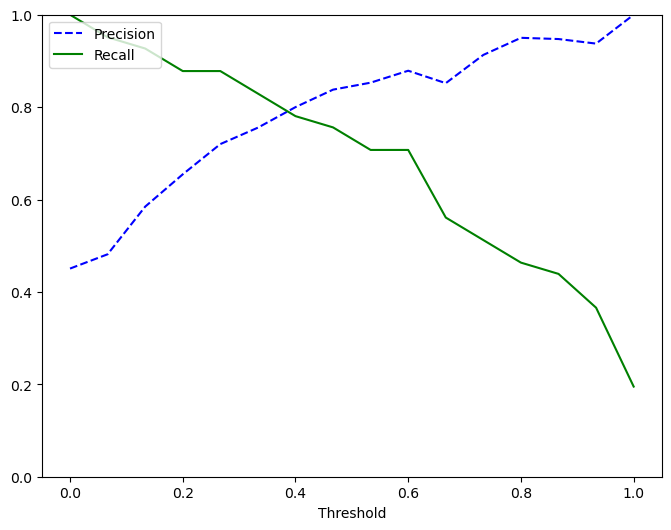

In [ ]:
#Precision recall tradeoff
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

#TOFILL

y_scores = knn.predict_proba(X_test_scaled)[:, 1]   # proba d'appartenir à la classe 1

# Courbe Precision-Recall vs threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)


rcParams['figure.figsize'] = 8,6
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)



As we can see, the lower the probability threshold, the higher the recall and the lower the precision. There is always a cost: this is what is called the precision/recall tradeoff. A classic way of seeing that is to plot the so-called precision-recall curve, with recall as abcissa and precision in ordinate. Plot it :

Average Precision (AP): 0.8570


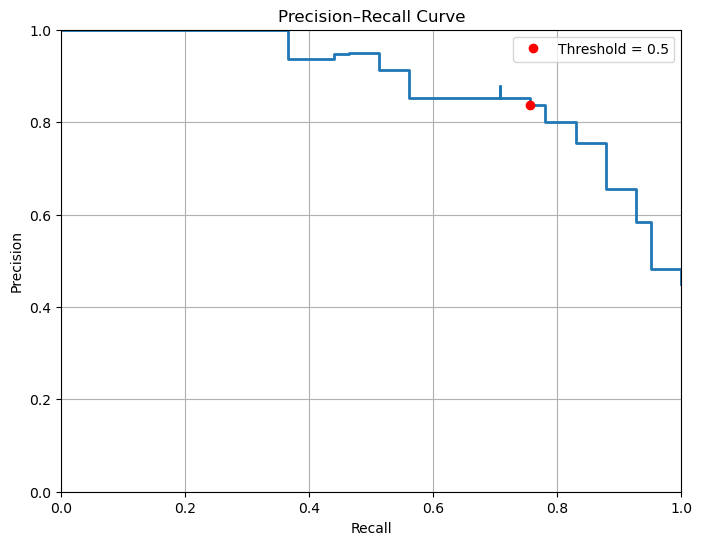

In [ ]:
def plot_precision_recall_curve(precisions, recalls):
    plt.step(recalls, precisions, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.grid(True)
    
#TOFILL
# Appel de la fonction
plot_precision_recall_curve(precisions, recalls)

# (Optionnel) afficher la moyenne (AP)
ap = average_precision_score(y_test, y_scores)
print(f"Average Precision (AP): {ap:.4f}")
idx = np.argmin(np.abs(thresholds - 0.5))
plt.plot(recalls[idx], precisions[idx], 'ro', label='Threshold = 0.5')
plt.legend()

Ce que le graphique montre :
Axe horizontal (x) → le Recall → plus on va vers la droite, plus le modèle détecte de vrais malades (moins de faux négatifs).    
Axe vertical (y) → la Precision (précision) → plus on monte, plus le modèle fait peu de fausses alertes (moins de faux positifs).   
Chaque point de la courbe correspond à un seuil de décision différent (threshold) appliqué aux probabilités du modèle.  


Le compromis “precision / recall trade-off” :
Quand on augmente le recall (on veut repérer plus de malades) : on accepte de baisser la précision (on risque plus de fausses alertes).   
Quand on augmente la précision : on devient plus strict → on ratera certains vrais malades (baisse du recall).

Autrement dit :  
Plus on veut être sûr de ne pas rater un malade (recall ↑), plus on risque d’en diagnostiquer à tort (precision ↓).  
C’est ce qu’on appelle le compromis precision / recall trade-off.

Le point rouge =>  Threshold = 0.5  
Ce point correspond au seuil par défaut du KNN et indique la performance du modèle avec ce seuil
on peut lire sa precision (axe vertical) et son recall (axe horizontal).  
Ici, le point est environ à recall ≈ 0.8, precision ≈ 0.8 → donc le modèle détecte environ 80 % des malades avec 80 % de précision=> plutôt bien je dirais  

Que se passe-t-il si on change le seuil ?  
Si on baisse le seuil (ex. 0.4 ou 0.3) : le modèle dira “malade” plus souvent → recall augmente, precision baisse.  
utile en médecine : mieux vaut rater moins de malades, même si on a plus de fausses alertes.

Si on augmente le seuil (> 0.5) : le modèle devient plus strict → precision augmente, recall baisse.   
utile si on veut éviter de fausses alarmes.

Here again, we can see the precision/recall trade-off. The better the classifier is, the closer the curve will be to the top-right corner. One way to summarize all these trade-offs in a single metric is to compute the area under the precision-recall curve, also called the *average precision* :

In [ ]:
from sklearn.metrics import average_precision_score

#TOFILL
y_scores = knn.predict_proba(X_test_scaled)[:, 1]

ap = average_precision_score(y_test, y_scores)
print(f"Average Precision (AP): {ap:.4f}")

Average Precision (AP): 0.8570


The average precision is generally the preferred metric if you can compute your test samples probabiliies, and if you care more about the positive class and/or have an imbalanced dataset.

So, let's not forget we are trying to diagnose people's heart disease. Let's say we are ready to accept to incorrectly label as healthy at most 5% of the patients that have a heart disease (false negatives), i.e. we want a recall of 0.95.
Given the threshold curve above, choose a threshold that approximately yields a recall of 0.95, and recompute the confusion matrix as well as precision:

L’Average Precision (AP) est une moyenne pondérée de la précision obtenue à différents niveaux de recall.  
Autrement dit, c’est l’aire sous la courbe (Area Under the Precision–Recall Curve, parfois notée PR AUC).

Elle résume toute la courbe en une seule valeur, entre 0 et 1 :
1.0 = modèle parfait,  
0.5 = modèle moyen,   
proche de 0 = modèle très mauvais.  

ap = average_precision_score(y_test, y_scores)  
Scikit-learn calcule cette moyenne en prenant en compte toutes les paires (precision, recall) pour chaque seuil testé.    
C’est donc un indicateur global : Plus la courbe est haute et proche du coin supérieur droit (precision et recall élevés en même temps),
plus l’AP est grande.


En contexte médical  
L’Average Precision permet de comparer globalement des modèles :  
Si le modèle a un AP proche de 1, il est efficace pour détecter les malades sans trop d’erreurs.  
Si la valeur AP est basse, cela veut dire que dès qu'on veut augmenter le recall, la precision s’effondre.  


Precision–Recall curve=> montre visuellement le compromis selon le seuil    
Average Precision (AP) => Moyenne de la précision sur tous les niveaux de rappel (≈ aire sous la courbe)    
Valeur élevée (proche de 1)=> Bon modèle, recall et precision élevés sur une large plage  
Valeur faible (proche de 0) => Mauvais compromis global  

Seuil choisi ≈ 0.0667
Average Precision (AP): 0.8570
Matrice de confusion (lignes = vrai, colonnes = prédit) [0/1]:
 [[23 27]
 [ 3 38]]
=== Évaluation du KNN with recall à 95% et seuil à 0.0667 ===
Accuracy : 0.6703
Precision: 0.5846
Recall   : 0.9268
F1-score : 0.7170
----------------------------------------


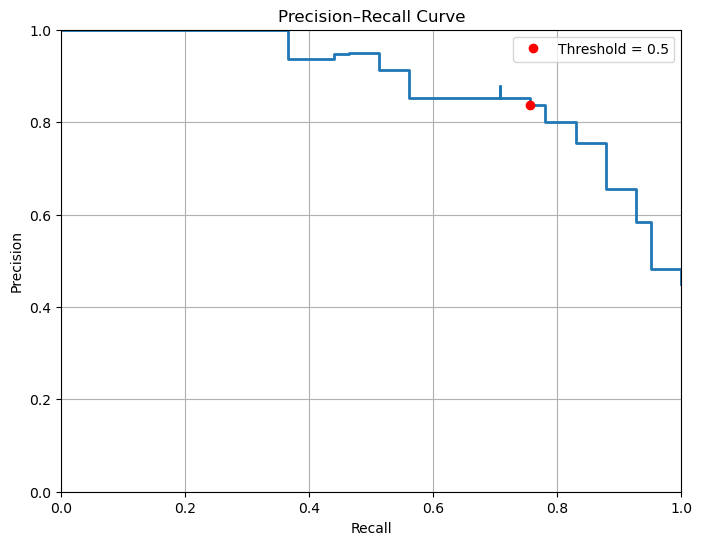

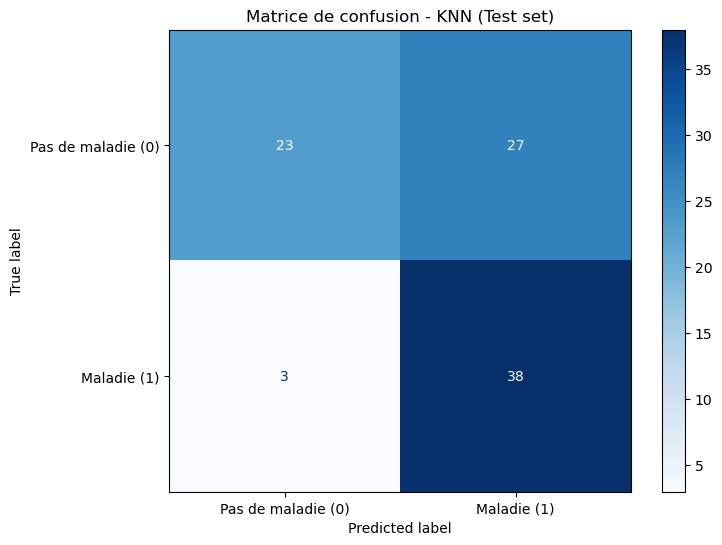

In [ ]:
#TOFILL


# 1) Courbe PR à partir des probabilités de la classe positive
# y_test_proba = knn.predict_proba(X_test_scaled)[:, 1]  # si pas déjà défini
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba)

target_recall = 0.95

# 2) Trouver le plus grand seuil tel que recall >= 0.95
# (attention: len(thresholds) = len(precisions) - 1 = len(recalls) - 1)
candidates = np.where(recalls[:-1] >= target_recall)[0]

if len(candidates) > 0:
    idx = candidates[-1]                 # plus grand seuil respectant la contrainte
    threshold = thresholds[idx]
else:
    # Si aucun point n'atteint 0.95, on prend le seuil minimal disponible (max recall)
    threshold = thresholds[0]
    print("⚠️ Aucun point n'atteint un recall de 0.95 ; on prend le seuil minimal pour maximiser le recall.")

print(f"Seuil choisi ≈ {threshold:.4f}")

# 3) Prédictions binaires avec ce seuil
y_cv_pred_95recall = (y_test_proba > threshold).astype(int)

# Appel de la fonction
plot_precision_recall_curve(precisions, recalls)

# (Optionnel) afficher la moyenne (AP)
ap = average_precision_score(y_test, y_scores)
print(f"Average Precision (AP): {ap:.4f}")
idx = np.argmin(np.abs(thresholds - 0.5))
plt.plot(recalls[idx], precisions[idx], 'ro', label='Threshold = 0.5')
plt.legend()


# 4) Métriques et matrice de confusion
cm = confusion_matrix(y_test, y_cv_pred_95recall, labels=[0, 1])
print("Matrice de confusion (lignes = vrai, colonnes = prédit) [0/1]:\n", cm)

eval_model(y_test, y_cv_pred_95recall, model_name="KNN with recall à 95% et seuil à 0.0667")

# 2️⃣ Affichage graphique
rcParams['figure.figsize'] = 8,6
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas de maladie (0)", "Maladie (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion - KNN (Test set)")
plt.show()




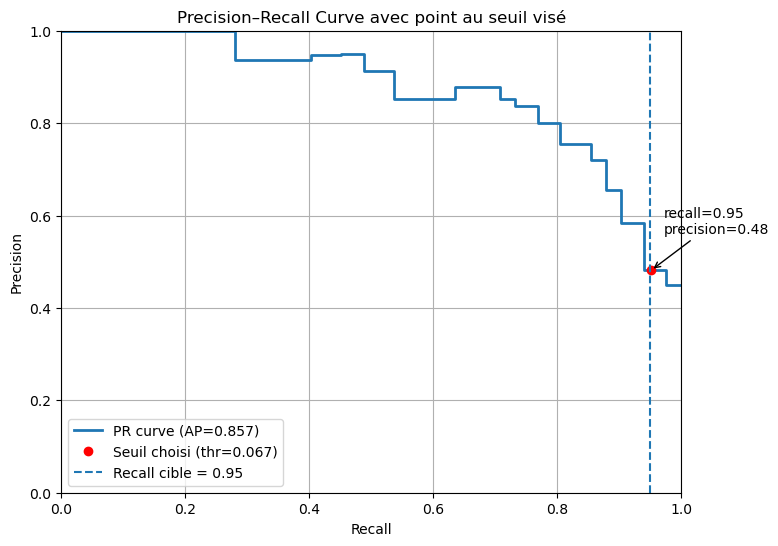

Point tracé → seuil=0.0667, recall=0.9512, precision=0.4815


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1) Courbe PR à partir des probabilités de la classe positive
# y_test_proba = knn.predict_proba(X_test_scaled)[:, 1]  # si pas déjà défini
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba)
ap = average_precision_score(y_test, y_test_proba)

target_recall = 0.95

# 2) Choisir l'indice du point à tracer (priorité: recall >= target, sinon le plus proche)
cand = np.where(recalls[:-1] >= target_recall)[0]   # -1 car thresholds est plus court d’un élément
if len(cand) > 0:
    idx = cand[-1]  # plus grand seuil qui garde recall >= target
else:
    # aucun seuil n'atteint 0.95 → on prend le point de recall le plus proche
    idx = np.argmin(np.abs(recalls[:-1] - target_recall))

thr_star = thresholds[idx]
prec_star = precisions[idx]
rec_star  = recalls[idx]

# 3) Plot PR curve + point au seuil choisi + ligne verticale à recall cible
plt.figure()
plt.step(recalls, precisions, where='mid', linewidth=2, label=f'PR curve (AP={ap:.3f})')
plt.plot(rec_star, prec_star, 'ro', label=f'Seuil choisi (thr={thr_star:.3f})')
plt.axvline(x=target_recall, linestyle='--', label=f'Recall cible = {target_recall:.2f}')

# Optionnel: annotation des valeurs
plt.annotate(f"recall={rec_star:.2f}\nprecision={prec_star:.2f}",
             xy=(rec_star, prec_star), xytext=(rec_star+0.02, min(1, prec_star+0.08)),
             arrowprops=dict(arrowstyle="->", lw=1))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve avec point au seuil visé")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.legend(loc="lower left")
plt.show()

print(f"Point tracé → seuil={thr_star:.4f}, recall={rec_star:.4f}, precision={prec_star:.4f}")

Fill the memo.txt file to answer these two questions:

3) Changing the threshold:    
a)What is the precision if we change the threshold to have a 0.95 recall ?      

Dans cette partie, l’objectif était de régler le seuil de décision du modèle de manière à atteindre un recall d’environ 95 %.
Autrement dit, on voulait que le modèle soit capable de détecter au moins 95 % des patients réellement malades, quitte à ce qu’il se trompe plus souvent en identifiant par erreur des personnes saines comme malades. 

Pour trouver ce seuil, on a utilisé la courbe de précision–rappel (Precision–Recall Curve), qui montre l’évolution de la précision et du rappel en fonction des différents seuils de probabilité.  
À partir des probabilités prédites par le modèle (y_test_proba), on a calculé tous les couples (recall, precision) pour chaque seuil, puis sélectionné le plus grand seuil permettant de conserver un recall supérieur 
ou égal à 0.95.
Cette approche nous a permis d’obtenir un seuil d’environ 0.0667.
Avec ce seuil, le modèle devient plus “sensible” : il classe plus facilement un patient comme “malade”, ce qui augmente la proportion de vrais positifs mais aussi celle de faux positifs. 

La précision associée à ce nouveau seuil diminue et est d’environ 48 % (0.4815).
Cela signifie que, parmi toutes les personnes identifiées comme malades, près de la moitié le sont réellement, tandis que l’autre moitié correspond à de fausses alertes.
Ce choix est cohérent avec le contexte médical :  
il vaut mieux signaler un risque de maladie chez un patient qui se révélera ensuite sain (faux positif) que rater un vrai malade (faux négatif).



b) How many patient were incorrectly diagnosed as being Healthy (false negatives)?   

La matrice de confusion obtenue avec ce seuil est la suivante : 
	           
		 Prédit  0	Prédit 1
Vrai 0 (sains)	23	37   
Vrai 1 (malades)	3	38    

On observe que 3 patients réellement malades ont été classés par erreur comme sains (Faux Négatifs), c’est-à-dire les malades que le modèle n’a pas su détecter.  
Même si ce nombre reste relativement faible, il montre pourquoi il est important, dans un contexte médical, de privilégier un haut rappel (recall) :   
réduire au maximum le risque de passer à côté d’un patient malade, même si cela entraîne davantage de fausses alertes.

## The Receiver Operating Characteristic (ROC) curve

(Yet) another way to look at your classfier performance, is to consider the false positive rate (FPR) instead of precision:


$$FPR= \frac{FP}{FP + TN}$$

This is the proportion of negative test samples that are incorrectly classified as positive. Plotting the FPR against the recall gives another classic evaluation curve, the ROC curve. 

In [ ]:
#The ROC curve
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (=Recall)')
    plt.title(f"ROC Curve (AUC = {auc:.3f})")
    plt.grid(True)
    plt.legend(loc="lower right")


#TOFILL

Here again there is a trade-off between TPR and FPR. Again, we can compute the area under this curve (AUC) :

ROC AUC: 0.8659


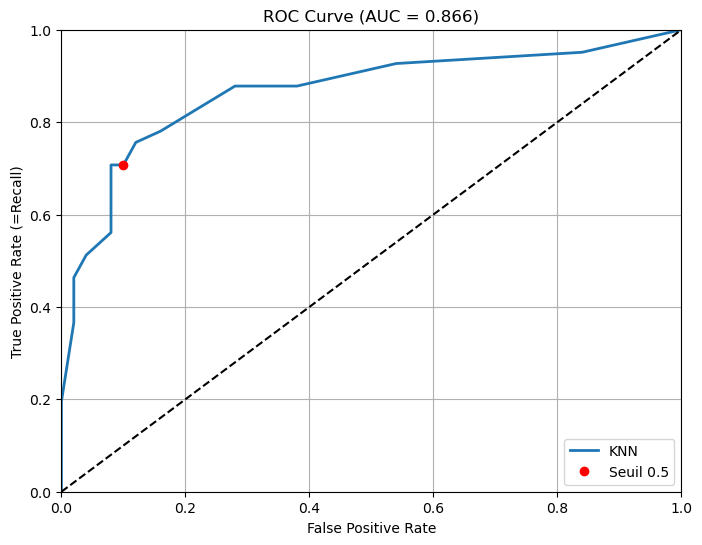

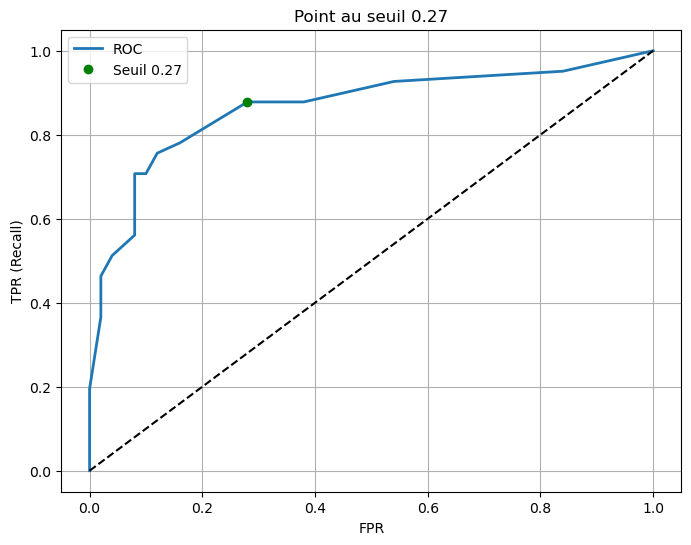

In [ ]:
from sklearn.metrics import roc_auc_score
#TOFILL

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC: {auc:.4f}")

# Plot ROC
plot_roc_curve(fpr, tpr, label="KNN")

# Marquer le point correspondant à threshold ≈ 0.5
idx_05 = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[idx_05], tpr[idx_05], 'ro', label='Seuil 0.5')
plt.legend(loc="lower right")
plt.show()

# # (Optionnel) Marquer un autre seuil, par ex. ton seuil "recall élevé"
thr_star = 0.27  # exemple: remplace par ton seuil
i_star = np.argmin(np.abs(thresholds - thr_star))
plt.figure()
plt.plot(fpr, tpr, linewidth=2, label="ROC")
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr[i_star], tpr[i_star], 'go', label=f'Seuil {thr_star:.2f}')
plt.xlabel('FPR'); plt.ylabel('TPR (Recall)'); plt.title(f"Point au seuil {thr_star:.2f}")
plt.grid(True); plt.legend();
plt.show()


Comment lire la ROC (très bref)

TPR (axe y) = Recall = part des vrais malades détectés.   
FPR (axe x) = part des sains faussement déclarés malades (1 – spécificité).   
AUC proche de 1 → excellent; 0.5 → aléatoire.  
Un point en haut à gauche est idéal (TPR haut, FPR bas).  
Le seuil déplace le point le long de la courbe : baisser le seuil ↑TPR mais ↑FPR.  

The ROC-AUC is useful when you can compute your test samples probabilities and care about how well ranked are your predictions, but it should be used when you have a balanced dataset and care equally about both targets, so we won't use it in the following because we care more about the positive class.

If you want to know more about all classification metrics and when to use them, you can read : https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

4/ Fill the memo.txt file to answer the following questions:

a) If I can compute my test sample probabilities and care more about the positive class, which overall metric should I use to compare classifiers ?    
Dans ce cas, la métrique la plus adaptée pour comparer les performances des classifieurs est l’AUC de la courbe ROC (Area Under the ROC Curve).  
Cette mesure prend en compte tous les seuils possibles et évalue la capacité globale du modèle à distinguer les deux classes (malade / sain).  

Plus précisément :   
L’axe des abscisses (FPR) représente la proportion de patients sains incorrectement prédits comme malades.  
L’axe des ordonnées (TPR = Recall) correspond à la proportion de vrais malades correctement détectés.  

L’AUC (Area Under Curve) correspond à l’aire sous cette courbe.  
Elle varie entre 0.5 (modèle aléatoire) et 1.0 (modèle parfait).  
Dans mon moèdle j'obitens une AUC = 0.8659, ce qui indique que mon modèle KNN est globalement très bon pour distinguer les patients malades des patients sains. 
Cette métrique est donc idéale lorsqu’on dispose des probabilités de prédiction, car elle prend en compte toute la gamme de seuils possibles et ne dépend pas d’un choix particulier (comme le seuil 0.5). 

b) And if I only have the class predictions and no probabilities ?    
Dans ce cas, on ne peut pas tracer la courbe ROC ni calculer l’AUC, car ces mesures nécessitent les scores continus (probabilités). 
On doit alors se limiter aux métriques calculées sur les classes prédictes, et on va alors choisir l'Accuracy, pour évaluer la proportion globale de bonnes prédictions, ou les Precision, Recall, et F1-score, pour analyser plus finement les performances du modèle, notamment sur la classe positive.   
Ces indicateurs permettent d’évaluer la qualité du modèle à un seuil fixe (souvent 0.5), mais ils ne capturent pas le comportement du modèle sur l’ensemble des seuils comme le fait la courbe ROC.

## Hyper-parameters search : the best number of neighbors

Now we know that in our case (we care more about the people who are sick, i.e. the positive class), the best way to compare classifiers with a single metric is *average precision* (AP), so we can start choosing the best hyper-parameter k. You have already studied the bias/variance tradeoff with linear regression. Here this is the same: with k=1 the bias will be 0, but the variance very high, and conversely with too high a k. In both cases, we will have a sub-optimal AP.

You can read more about the bias/variance trade-off with KNNs here: https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb


Let's search for the value of k that gives the best AP score, by doing a grid-search as you already did with linear regression, but first lets play a bit with the value of k. As you have already learnt, to choose the best hyper-parameters, we leave the test set aside, and do a *cross-validation* on the train set, from which we can compute *validation metrics* for each hyper-parameter combination to select them. You can remind yourself about cross-validation here:

https://scikit-learn.org/stable/modules/cross_validation.html

Plot the PR curve and compute the mean validation APs with k=15, 30 and 50 by doing a 5-fold cross-validation over the training set :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score

# Hypothèses: X_train_scaled (numpy array ou DataFrame) et y_train existent déjà
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)

ks = [15, 30, 50]
ap_results = {}

plt.figure(figsize=(7,5))

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)  # weights="uniform" par défaut

    # 1) AP moyen via 5-fold CV (sur le TRAIN)
    scores = cross_val_score(
        knn, X_train_scaled, y_train,
        cv=cv, scoring='average_precision', n_jobs=-1
    )
    ap_results[k] = (scores.mean(), scores.std())

    # 2) Scores out-of-fold pour tracer la PR curve honnête
    y_scores_oof = cross_val_predict(
        knn, X_train_scaled, y_train,
        cv=cv, method='predict_proba', n_jobs=-1
    )[:, 1]

    precisions, recalls, _ = precision_recall_curve(y_train, y_scores_oof)
    ap_oof = average_precision_score(y_train, y_scores_oof)

    plt.step(recalls, precisions, where='mid', linewidth=2,
             label=f'k={k} (AP OOF={ap_oof:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall (5-fold CV, out-of-fold) — KNN sans preprocessing')
plt.xlim([0, 1]); plt.ylim([0, 1]); plt.grid(True)
plt.legend(loc='lower left')
plt.show()

# Récapitulatif des AP moyens (validation croisée)
for k in ks:
    m, s = ap_results[k]
    print(f"k={k:>2}: mean AP (5-fold) = {m:.4f} ± {s:.4f}")

KeyboardInterrupt: 

<Figure size 700x500 with 0 Axes>

To automatically select the k value that yields the best mean validation AP, use the *GridSearchCV* class to perform a grid search by doing a 5-fold cross validation on the train set with k ranging froom 0 to 100, and print the best mean AP on the cross validation and the best k value:

Best mean validation AP (5-fold): 0.8937
Best k: 53
Mean ROC AUC (5-fold) at best k: 0.8970


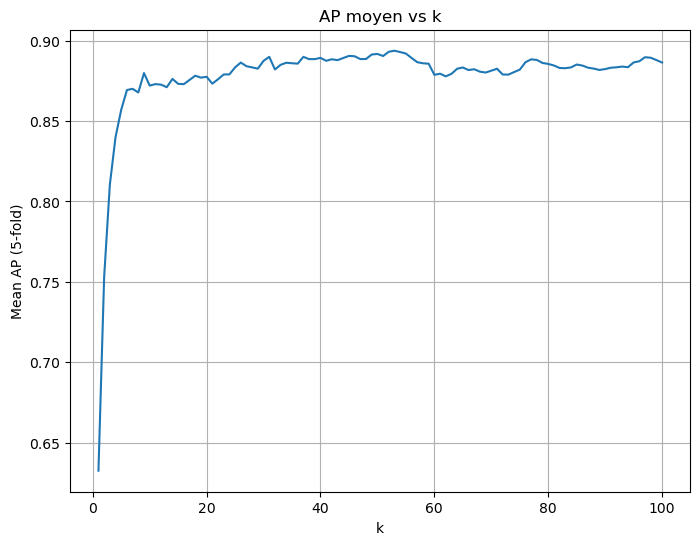

In [ ]:
#Grid search k and give its roc auc score:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

k_range = range(1,101)
param_grid =  {'n_neighbors': k_range}
knn_clf = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)


# GridSearch pour maximiser l'Average Precision (AP)
grid = GridSearchCV(
    estimator=knn_clf,
    param_grid=param_grid,
    scoring='average_precision',   # métrique demandée
    cv=cv,
    n_jobs=-1,
    refit=True,                    # refit sur tout le train avec le meilleur k
    return_train_score=False
)

grid.fit(X_train_scaled, y_train)

best_k = grid.best_params_['n_neighbors']
best_ap = grid.best_score_

print(f"Best mean validation AP (5-fold): {best_ap:.4f}")
print(f"Best k: {best_k}")

# (Optionnel) aussi la ROC AUC moyenne pour ce k (toujours en CV sur le train)
best_knn = KNeighborsClassifier(n_neighbors=best_k)
roc_auc_cv = cross_val_score(
    best_knn, X_train_scaled, y_train,
    cv=cv, scoring='roc_auc', n_jobs=-1
).mean()
print(f"Mean ROC AUC (5-fold) at best k: {roc_auc_cv:.4f}")

ks = grid.cv_results_['param_n_neighbors'].data.astype(int)
plt.plot(ks, grid.cv_results_['mean_test_score']); plt.xlabel("k"); plt.ylabel("Mean AP (5-fold)"); plt.title("AP moyen vs k"); plt.grid(True)

Now let's retrain a model with the optimal value of k obtained on the train set, and find a theshold that gives a recall of 0.95 or higher on the test set. Recompute the precision on the test set and compare it to the one you obtained before grid searching for the optimal value of k.

In [ ]:
#TOFILL
TARGET_RECALL = 0.95

# Récupérer best_k depuis la grid si besoin
try:
    best_k = best_k
except NameError:
    try:
        best_k = grid.best_params_['n_neighbors']
    except:
        raise RuntimeError("best_k introuvable : définis-le (ex: best_k = grid.best_params_['n_neighbors']).")

def precision_at_recall(model, X_test, y_test, target_recall=0.95):
    """Entraîne déjà fait; calcule proba test, choisit le plus grand seuil avec recall>=cible,
       retourne precision, recall, threshold et la confusion matrix."""
    y_scores = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # indices possibles avec recall >= cible (attention: thresholds a une longueur de n-1)
    cand = np.where(recalls[:-1] >= target_recall)[0]
    if len(cand) > 0:
        idx = cand[-1]  # plus grand seuil qui respecte la contrainte
    else:
        # aucun point n'atteint la cible -> prendre le recall max (seuil minimal)
        idx = 0
        print("⚠️ Aucun seuil n'atteint le recall demandé, on prend le seuil minimal (max recall).")

    thr = thresholds[idx]
    y_pred = (y_scores >= thr).astype(int)

    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    cm   = confusion_matrix(y_test, y_pred, labels=[0,1])
    return prec, rec, thr, cm

# --- 1) Modèle optimisé (best_k) ---
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)

prec_best, rec_best, thr_best, cm_best = precision_at_recall(
    knn_best, X_test_scaled, y_test, TARGET_RECALL
)

print(f"[BEST k={best_k}] seuil choisi={thr_best:.4f} | Recall={rec_best:.4f} | Precision={prec_best:.4f}")
print("Matrice de confusion (Vrai en lignes, Prédit en colonnes) :\n", cm_best)


# --- 2) Modèle de référence avant grid-search (ex: k=15) ---
k_baseline = 15
knn_base = KNeighborsClassifier(n_neighbors=k_baseline)
knn_base.fit(X_train_scaled, y_train)

prec_base, rec_base, thr_base, cm_base = precision_at_recall(
    knn_base, X_test_scaled, y_test, TARGET_RECALL
)

print(f"\n[BASELINE k={k_baseline}] seuil choisi={thr_base:.4f} | Recall={rec_base:.4f} | Precision={prec_base:.4f}")
print("Matrice de confusion (Vrai en lignes, Prédit en colonnes) :\n", cm_base)

# --- 3) Comparaison ---
delta = prec_best - prec_base
print(f"\nΔ Precision (best_k - baseline) = {delta:+.4f}")

[BEST k=53] seuil choisi=0.1887 | Recall=0.9756 | Precision=0.6349
Matrice de confusion (Vrai en lignes, Prédit en colonnes) :
 [[27 23]
 [ 1 40]]

[BASELINE k=15] seuil choisi=0.0667 | Recall=0.9512 | Precision=0.4815
Matrice de confusion (Vrai en lignes, Prédit en colonnes) :
 [[ 8 42]
 [ 2 39]]

Δ Precision (best_k - baseline) = +0.1534


Le delta de la précision est positif après la GridSearch (avec le meilleur k) : précision plus haute que la précision du modèle avant (“baseline”) avec k=15

Autrement dit :
le nouveau modèle détecte plus de vrais malades (Recall haut, c’est ce qu’on voulait)
et il se trompe moins souvent en déclarant des patients malades alors qu’ils ne le sont pas.
0.6349 - 0.4815 => +0.1534

C'est plutôt un bon résultat
moins de faux négatifs (FN) → meilleur recall,  
moins de faux positifs (FP) → meilleure precision.   

Il est important de noter que dans certtaines situtations, quand on augmente le recall ka précision baisse
il faut faire odnc un compromis entre recall et precision :
Plus on peut détecter de malades (recall ↑), plus on risque de fausses alertes (precision ↓).
du point de vu médical => 
“Il est plus important de ne pas dire qu’un malade est en bonne santé, quitte à suspecter certains patients sains.”

## Parity between Men and Women

Our dataset actually contains more men than women. Men are encoded with 1 in the *sex* column, and women with 0. Compute the men/women ratio :

In [ ]:
#TOFILL
TabSex=dataset['sex'].value_counts()
print(TabSex)
women=TabSex[0]
men=TabSex[1]
ratio=men/women
print("le ratio men/women est de:", ratio, "dans le jeu de données")


sex
1    207
0     96
Name: count, dtype: int64
le ratio men/women est de: 2.15625 dans le jeu de données


This could have the effect of having a model biased towards men, that will have a lower precision and recall on women. Medicine has a long-standing history of gender bias. Not only men have been more numerous in clinical studies, but this also had the effect of delaying diagnosis on women, who hence exhibited different symptoms when diagnosed, which could be another source of bias for our model :

https://theconversation.com/gender-bias-in-medicine-and-medical-research-is-still-putting-womens-health-at-risk-156495

To check this, recompute precision and recall (using the last threshold you obtained to get a 0.95 recall), but separately for the men and the women in the test set :

In [ ]:
#TOFILL
threshold=thr_best
print("Seuil de ",thr_best," définis avec recall de 95%")

# Prédictions binaires avec le seuil trouvé
y_test_pred_thr = (y_test_proba >= threshold).astype(int)

# Identification des indices des hommes et des femmes
men_idx = X_test.index[dataset.loc[X_test.index, 'sex'] == 1]
women_idx = X_test.index[dataset.loc[X_test.index, 'sex'] == 0]

# vraies valeurs et prédictions par groupe
y_true_men = y_test.loc[men_idx]
y_pred_men = y_test_pred_thr[np.isin(X_test.index, men_idx)]

y_true_women = y_test.loc[women_idx]
y_pred_women = y_test_pred_thr[np.isin(X_test.index, women_idx)]

# Calcul des métriques
prec_men = precision_score(y_true_men, y_pred_men)
rec_men = recall_score(y_true_men, y_pred_men)

prec_women = precision_score(y_true_women, y_pred_women)
rec_women = recall_score(y_true_women, y_pred_women)

# matrices de confusion pour les deux groupes
cm_men = confusion_matrix(y_true_men, y_pred_men, labels=[0,1])
cm_women = confusion_matrix(y_true_women, y_pred_women, labels=[0,1])

print("=== Hommes ===")
print("Matrice de confusion :\n", cm_men)
eval_model(y_true_men,y_pred_men,model_name="Model Homme avec seuil à 0.1887")

print("=== Femmes ===")
print("Matrice de confusion :\n", cm_women)
eval_model(y_true_women,y_pred_women,model_name="Model Femme avec seuil à 0.1887")



Seuil de  0.18867924528301888  définis avec recall de 95%
=== Hommes ===
Matrice de confusion :
 [[18 10]
 [ 3 31]]
=== Évaluation du Model Homme avec seuil à 0.1887 ===
Accuracy : 0.7903
Precision: 0.7561
Recall   : 0.9118
F1-score : 0.8267
----------------------------------------
=== Femmes ===
Matrice de confusion :
 [[13  9]
 [ 2  5]]
=== Évaluation du Model Femme avec seuil à 0.1887 ===
Accuracy : 0.6207
Precision: 0.3571
Recall   : 0.7143
F1-score : 0.4762
----------------------------------------


{'accuracy': 0.6206896551724138,
 'precision': 0.35714285714285715,
 'recall': 0.7142857142857143,
 'f1': 0.47619047619047616}

Indeed we can see that both recall and precision are much lower on women !

Learn about bias in machine learning models, the different definitions of parity and how to enforce them by reading the following article :

https://www.labelia.org/en/blog/fairness-in-machine-learning

In our case we want to enforce the equality of Opportunity (= same True Positive Rate, = same Recall), since we don't want to miss more women with a heart disease than men. 

One way to enforce this is to choose a different threshold that yields a Recall > 0.95 for each group (men and women). Find such thresholds :

In [ ]:
#TOFILL
# Données par groupe

y_proba_men = y_test_proba[np.isin(X_test.index, men_idx)]
y_proba_women = y_test_proba[np.isin(X_test.index, women_idx)]

target_recall = 0.95

def threshold_for_recall(y_true, y_scores, target=0.95):
    prec, rec, thr = precision_recall_curve(y_true, y_scores)
    # thr a une taille de len(prec)-1
    cand = np.where(rec[:-1] >= target)[0]
    if len(cand) > 0:
        idx = cand[-1]             # plus grand seuil respectant recall >= target
    else:
        # Si impossible d'atteindre 0.95, prendre le point le plus proche en rappel
        idx = int(np.argmin(np.abs(rec[:-1] - target)))
        print("⚠️ Aucun seuil n'atteint exactement le recall cible ; seuil choisi pour le rappel le plus proche.")
    return thr[idx], prec[idx], rec[idx]

# Seuils par groupe
thr_m, prec_at_m, rec_at_m = threshold_for_recall(y_true_men, y_proba_men, target_recall)
thr_w, prec_at_w, rec_at_w = threshold_for_recall(y_true_women, y_proba_women, target_recall)

print(f"Seuil hommes  (≥{target_recall:.2f} recall) ≈ {thr_m:.4f} | precision={prec_at_m:.4f} | recall={rec_at_m:.4f}")
print(f"Seuil femmes  (≥{target_recall:.2f} recall) ≈ {thr_w:.4f} | precision={prec_at_w:.4f} | recall={rec_at_w:.4f}")

# Prédictions binaires avec seuils spécifiques
y_pred_men = (y_proba_men >= thr_m).astype(int)
y_pred_women = (y_proba_women >= thr_w).astype(int)

# Métriques finales par groupe
cm_men = confusion_matrix(y_true_men, y_pred_men, labels=[0,1])
cm_women = confusion_matrix(y_true_women, y_pred_women, labels=[0,1])

prec_men = precision_score(y_true_men, y_pred_men, zero_division=0)
rec_men  = recall_score(y_true_men, y_pred_men)
prec_women = precision_score(y_true_women, y_pred_women, zero_division=0)
rec_women  = recall_score(y_true_women, y_pred_women)

print("\n=== Hommes (seuil spécifique) ===")
eval_model(y_true_men,y_pred_men,model_name="Model Homme avec seuil spécifique Homme et recall Homme >95%")

print("\n=== Femmes (seuil spécifique) ===")
print("Matrice de confusion:\n", cm_women)
eval_model(y_true_women,y_pred_women,model_name="Model Homme avec seuil spécifique Femme, et recall Femme >95%")

Seuil hommes  (≥0.95 recall) ≈ 0.0667 | precision=0.6111 | recall=0.9706
Seuil femmes  (≥0.95 recall) ≈ 0.0000 | precision=0.2414 | recall=1.0000

=== Hommes (seuil spécifique) ===
=== Évaluation du Model Homme avec seuil spécifique Homme et recall Homme >95% ===
Accuracy : 0.6452
Precision: 0.6111
Recall   : 0.9706
F1-score : 0.7500
----------------------------------------

=== Femmes (seuil spécifique) ===
Matrice de confusion:
 [[ 0 22]
 [ 0  7]]
=== Évaluation du Model Homme avec seuil spécifique Femme, et recall Femme >95% ===
Accuracy : 0.2414
Precision: 0.2414
Recall   : 1.0000
F1-score : 0.3889
----------------------------------------


{'accuracy': 0.2413793103448276,
 'precision': 0.2413793103448276,
 'recall': 1.0,
 'f1': 0.3888888888888889}

The automation of discrimination through biased machine learning models is a raising concern, there are many resources of interest in the *Bibliography* section of the above article to learn about it. Be sure to check for biases in your future models !

Recall ≥ 0.95 dans chaque groupe (Equal Opportunity).  

Hommes (seuil ≈ 0.0667)
Confusion: TN=7, FP=21, FN=1, TP=33
→ Recall = 0.9706 (très haut), Precision = 0.6111
→ FPR (taux de faux positifs) = FP/(FP+TN) = 21/28 ≈ 0.75 (élevé)

Femmes (seuil ≈ 0.0000)
Confusion: TN=0, FP=22, FN=0, TP=7
→ Recall = 1.00, Precision = 0.2414
→ FPR = 22/(22+0) = 1.00 (tout le monde prédit “malade”)


En imposant Equal Opportunity (Recall ≥ 0.95) séparément chez les hommes et chez les femmes, on atteint bien un TPR élevé dans les deux groupes, mais au prix d’une forte augmentation du FPR, surtout chez les femmes (seuil ~0 ⇒ toutes les femmes sont prédites positives).  
La précision chute en conséquence (≈0.24 chez les femmes, ≈0.61 chez les hommes). Ce résultat illustre le trade-off entre équité sur le TPR et coût en faux positifs. 
Des alternatives consistent à diminuer la target recall => ex. 0.90? ou à calibrer les probabilités 



# Going further : Try out other classification models

## Decision Trees 

Decision trees can be very useful when you need to understand how the classifier chooses the classes. You can read more about it there:

https://en.wikipedia.org/wiki/Decision_tree_learning

https://scikit-learn.org/stable/modules/tree.html

Train a decision tree with *max_depth=3*, and use the  sklearn.tree.plot_tree function to visualize it (use the *feature_names* and *class_names* parameters to have useful infos in the tree visualization).

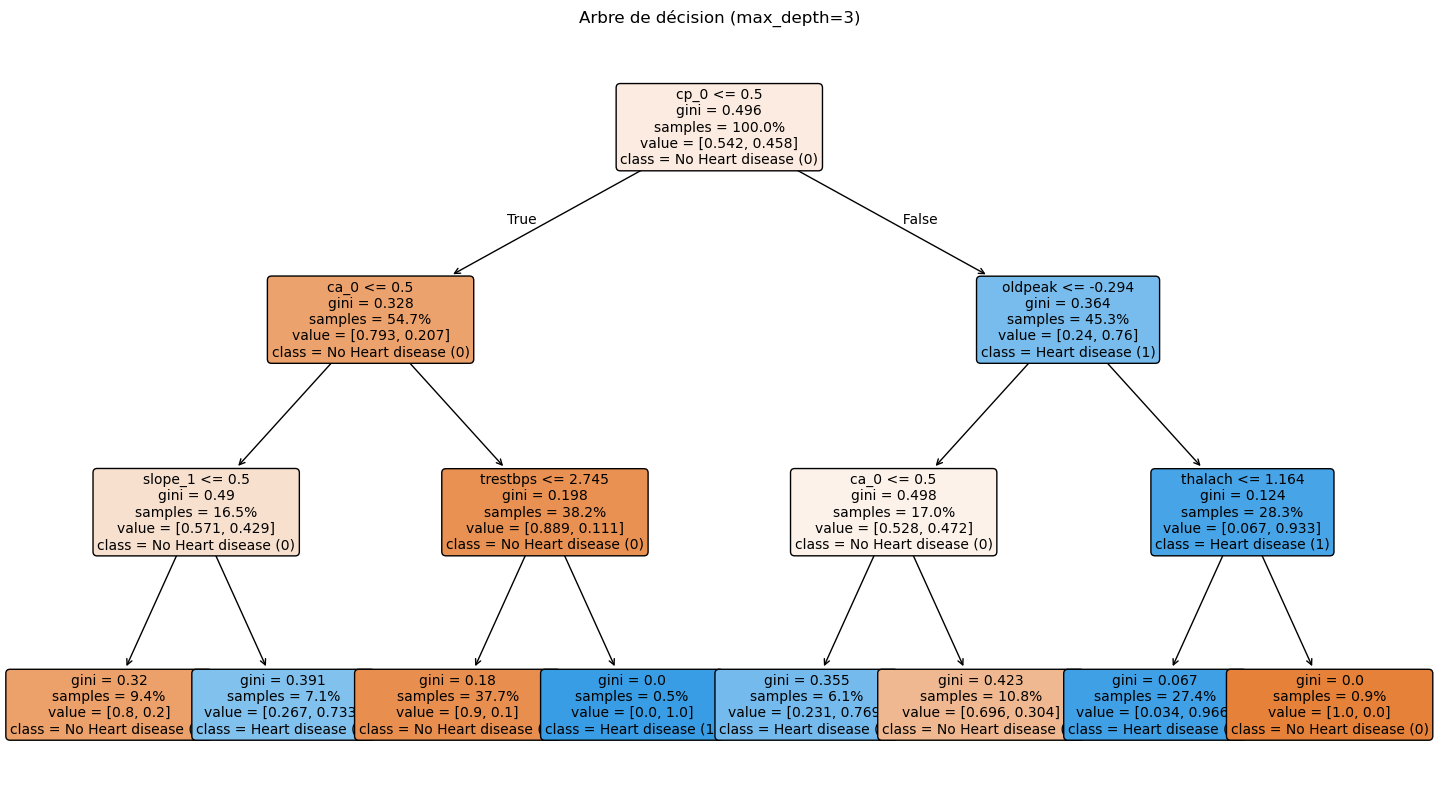

=== Évaluation du Decision tree Classifier with max depth = 3 ===
Accuracy : 0.8132
Precision: 0.7857
Recall   : 0.8049
F1-score : 0.7952
----------------------------------------


{'accuracy': 0.8131868131868132,
 'precision': 0.7857142857142857,
 'recall': 0.8048780487804879,
 'f1': 0.7951807228915663}

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

max_depth = 3

# 1) Récupérer les noms de features
if isinstance(X_train_scaled, pd.DataFrame):
    feature_names = X_train_scaled.columns.tolist()
else:
    feature_names = [f"feat_{i}" for i in range(X_train_scaled.shape[1])]

# 2) Définir des noms de classes lisibles (0=pas de maladie, 1=maladie)
#    On respecte l'ordre des classes appris par le modèle (clf.classes_)
class_names = ["No Heart disease (0)", "Heart disease (1)"]

# 3) Entraîner l'arbre de décision
clf = DecisionTreeClassifier(max_depth=max_depth,random_state=41)
clf.fit(X_train_scaled, y_train)

# 4) Visualisation de l'arbre
plt.figure(figsize=(18, 10))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    proportion=True,   # affiche les proportions dans les nœuds
    fontsize=10
)
plt.title("Arbre de décision (max_depth=3)")
plt.show()

# 5) Évaluation rapide sur le test
y_pred_clf = clf.predict(X_test_scaled)
from sklearn.metrics import accuracy_score, classification_report

eval_model(y_test,y_pred_clf,model_name="Decision tree Classifier with max depth = 3")




## Vue d’ensemble ##

L'arbre de décision a été effectuée pour prédire la présence d’une maladie du cœur (Heart disease = 1), avec une profondeur maximale de 3, donc un modèle interprétable et compact.
Les nœuds représentent des tests sur des variables (ex: cp_0 <= 0.5).   
Les feuilles représentent des prédictions (classe 0 = pas de maladie, classe 1 = maladie).

La couleur indique la classe majoritaire :  
orange → “Pas de maladie” (classe 0)  
bleu → “Maladie du cœur” (classe 1)   

Le Gini mesure l’impureté (0 = homogène, 0.5 = mélange égal).   
La valeur [x, y] correspond à la proportion d’échantillons appartenant à chaque classe (0 puis 1).   



## Interprétation du haut de l’arbre##

### Nœud racine : cp_0 <= 0.5 ### 
cp = chest pain type (type de douleur thoracique)  
cp_0 correspond probablement à une des modalités (par ex. douleur typique angineuse).  
Si cp_0 <= 0.5 (donc pas ce type de douleur), on va à gauche → tendance à pas de maladie.  
Sinon, on va à droite → plus de probabilité de maladie.   
Conclusion : le type de douleur thoracique est la variable la plus discriminante.   



### Branche gauche (patients sans douleur typique) ###
ca_0 <= 0.5   
ca = nombre de vaisseaux colorés (lié à l’obstruction coronarienne)    
Si ca_0 <= 0.5 (donc probablement plusieurs vaisseaux bloqués), on continue vers maladie.  
Sinon, vers pas de maladie. 

Les sous-nœuds utilisent slope_1 (pente du segment ST) et trestbps (pression au repos).  
Ces critères affinent le diagnostic, mais globalement cette branche reste orientée vers la non-maladie.  
Les feuilles de cette branche sont surtout orange → beaucoup de patients sans maladie.
≈ 80 % de non-malades contre 20 % de malades.  



### Branche droite (patients avec douleur thoracique typique)###
oldpeak <= -0.294  
oldpeak = dépression du segment ST induite par l’effort (indicateur d’ischémie cardiaque)   
Si cette valeur est faible (≤ -0.294), alors plus de risque de maladie.  

Cette branche conduit à des nœuds très bleus : forte probabilité de maladie.   
thalach (fréquence cardiaque max atteinte) affine la décision :
Si thalach <= 1.164 → 93 % de patients malades.  
Sinon → probabilité un peu plus équilibrée, mais encore orientée vers la maladie.  

Cette partie droite est presque toute bleue → les patients ici présentent des signes clairs de pathologie cardiaque. 


## Lecture des métriques dans les nœuds## 
oldpeak <= -0.294  
gini = 0.364  
samples = 45.3%  
value = [0.24, 0.76]  
class = Heart disease (1)  

signifie que :   
ce nœud contient 45,3 % de l’échantillon total,  
environ 76 % des patients de ce groupe ont une maladie,   
le Gini (0.364) montre une proportion encore mélangée mais déjà très orientée,   
la classe prédite est donc “Heart disease”.   

Grid search over the 'max_depth' parameter and compute the the best ROC-AUC for the decision tree:

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Top 10 configurations (CV):


,rank_test_score,ROC_AUC_Test,ROC_AUC_std_Test,ROC_AUC_Train,ROC_AUC_std_Train,param_max_depth,DeltaTrainTest
0,3,0.777197,0.087362,0.776299,0.009647,1,0.000898
1,2,0.815976,0.071719,0.863244,0.008232,2,0.047267
2,1,0.827264,0.048606,0.915213,0.007207,3,0.087948
3,4,0.769061,0.091039,0.952849,0.007440,4,0.183788
4,7,0.729415,0.095441,0.983828,0.005339,5,0.254413
20,5,0.737298,0.067515,1.000000,0.000000,21,0.262702
49,6,0.734217,0.064123,1.000000,0.000000,50,0.265783
5,11,0.727370,0.043201,0.995242,0.002820,6,0.267872
43,8,0.728409,0.089496,1.000000,0.000000,44,0.271591
56,9,0.728232,0.080900,1.000000,0.000000,57,0.271768


DecisionTreeClassifier(max_depth=3)
Test ROC AUC (best CLF): 0.8027


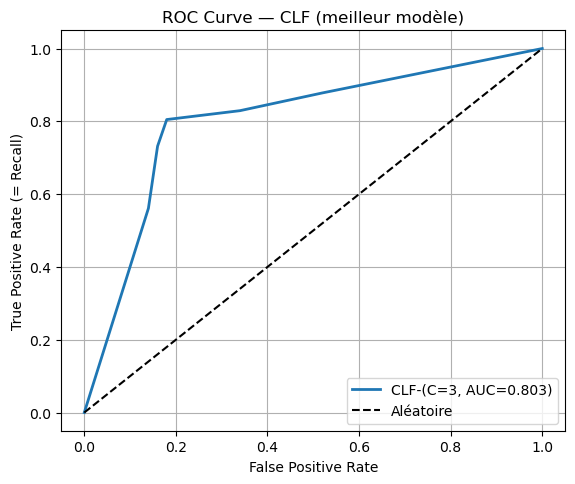

In [ ]:
#TOFILL
depth_range = range(3,100)
param_gridCLF =  {'max_depth': k_range}

clf = DecisionTreeClassifier()
clf=clf.fit(X_train_scaled, y_train)

# GridSearch pour maximiser l'Average Precision (AP)
gridCLF = GridSearchCV(
    estimator=clf,
    param_grid=param_gridCLF,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    verbose=10,              
    return_train_score=True
)

gridCLF.fit(X_train_scaled, y_train)

# ------------- 1) Résultats du GridSearch en DataFrame propre -------------
cvdfCLF = pd.DataFrame(gridCLF.cv_results_).copy()

# Colonnes d'hyperparamètres (dynamiques)
param_colsCLF = [c for c in cvdfCLF.columns if c.startswith("param_")]

# Métriques lisibles (CV)
cvdfCLF["ROC_AUC_Test"]  = cvdfCLF["mean_test_score"]            # car 'neg_mean_squared_error'
# Ecart-type (approx) de la RMSE via delta method
cvdfCLF["ROC_AUC_std_Test"] = cvdfCLF["std_test_score"].abs()

# (optionnel) si tu avais return_train_score=True
if "mean_train_score" in cvdfCLF:
    cvdfCLF["ROC_AUC_Train"] =cvdfCLF["mean_train_score"]
    cvdfCLF["ROC_AUC_std_Train"] = cvdfCLF["std_train_score"].abs() 
    
# Tableau compact et trié (meilleurs en haut)
tableCLF = cvdfCLF[["rank_test_score","ROC_AUC_Test","ROC_AUC_std_Test","ROC_AUC_Train",'ROC_AUC_std_Train'] + param_colsCLF]
tableCLF = tableCLF.reset_index(drop=True)
tableCLF["DeltaTrainTest"]=(tableCLF.ROC_AUC_Train-tableCLF.ROC_AUC_Test).abs()
tableCLF=tableCLF.sort_values("DeltaTrainTest")
print("Top 10 configurations (CV):")
display(tableCLF.head(10))   # ou print(table.head(10).to_string(index=False))
best_tree = gridCLF.best_estimator_
print(best_tree)


# === 3) ROC AUC sur le TEST ===
# utilisation du decision_function pour l'AUC

y_scores_testCLF = gridCLF.best_estimator_.predict_proba(X_test_scaled)[:, 1]
test_aucCLF = roc_auc_score(y_test, y_scores_testCLF)
print(f"Test ROC AUC (best CLF): {test_aucCLF:.4f}")

# === 4) Courbe ROC sur le TEST ===
fpr, tpr, thr = roc_curve(y_test, y_scores_testCLF)
plt.figure(figsize=(6.5,5.2))
plt.plot(fpr, tpr, label=f"CLF-(C={gridCLF.best_params_['max_depth']}, AUC={test_aucCLF:.3f})", linewidth=2)
plt.plot([0,1],[0,1],'k--', label="Aléatoire")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (= Recall)")
plt.title("ROC Curve — CLF (meilleur modèle)")
plt.grid(True); plt.legend(loc="lower right")
plt.show()


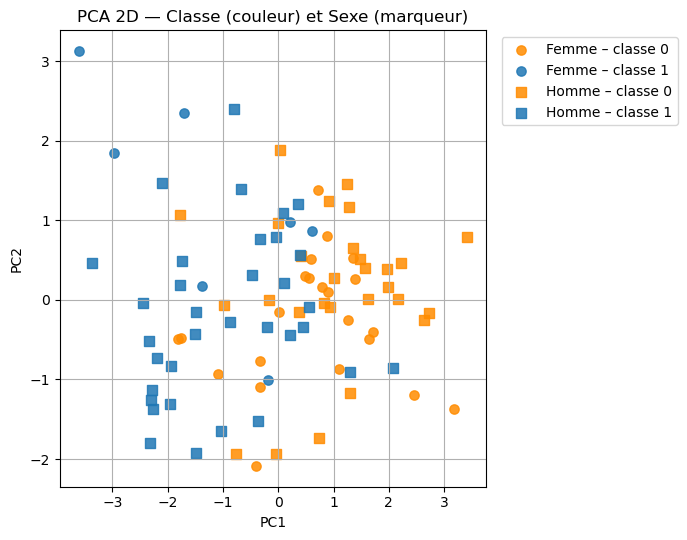

In [ ]:
#### Essai de plot PCA 
X_vis = X_test_scaled
y_vis = y_test
sex_vis = dataset.loc[X_test.index, 'sex'].values  # 1=H, 0=F

Z = PCA(n_components=2, random_state=41).fit_transform(X_vis)

markers = {0: "o", 1: "s"}   # F = rond, H = carré
labels_sex = {0: "Femme", 1: "Homme"}
colors = {0: "#FF8C00", 1: "#1f77b4"}  # 0=orange, 1=bleu

plt.figure(figsize=(7,5.5))
for sex in [0,1]:
    for cls in [0,1]:
        m = (sex_vis == sex) & ((y_vis.values if hasattr(y_vis,'values') else y_vis) == cls)
        plt.scatter(Z[m,0], Z[m,1], s=45, alpha=0.85,
                    c=colors[cls], marker=markers[sex],
                    label=f"{labels_sex[sex]} – classe {cls}")

# éviter les doublons dans la légende
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
plt.legend(uniq.values(), uniq.keys(), bbox_to_anchor=(1.02, 1), loc="upper left")

plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA 2D — Classe (couleur) et Sexe (marqueur)")
plt.grid(True); plt.tight_layout()
plt.show()

## Support Vector Machines

In general Support Vector Machines (SVM) is the classification method that often gives the best predictive performances. You can read about it there:

https://scikit-learn.org/stable/modules/svm.html (beginning of section 1.4.7 gives an intuitive view of the principles of SVMs)

Similarly, grid search over the 'C' parameter and compare ROC AUC scores:

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Top 10 configurations (CV):


,rank_test_score,ROC_AUC_Test,ROC_AUC_std_Test,ROC_AUC_Train,ROC_AUC_std_Train,param_C,DeltaTrainTest
5,1,0.905522,0.050854,0.929006,0.004516,0.100000,0.023484
3,2,0.901002,0.053623,0.924689,0.004336,0.001000,0.023688
0,3,0.900909,0.054584,0.924646,0.004324,0.000001,0.023737
1,3,0.900909,0.054584,0.924646,0.004324,0.000010,0.023737
2,3,0.900909,0.054584,0.924646,0.004324,0.000100,0.023737
4,7,0.899167,0.056120,0.924689,0.004348,0.010000,0.025523
6,6,0.900530,0.046659,0.974531,0.002844,1.000000,0.074001
7,8,0.858342,0.047481,0.999923,0.000086,10.000000,0.141581
8,9,0.832130,0.053051,1.000000,0.000000,100.000000,0.167870
9,9,0.832130,0.053051,1.000000,0.000000,1000.000000,0.167870


SVC(C=0.1)
Test ROC AUC (best SVM): 0.8834


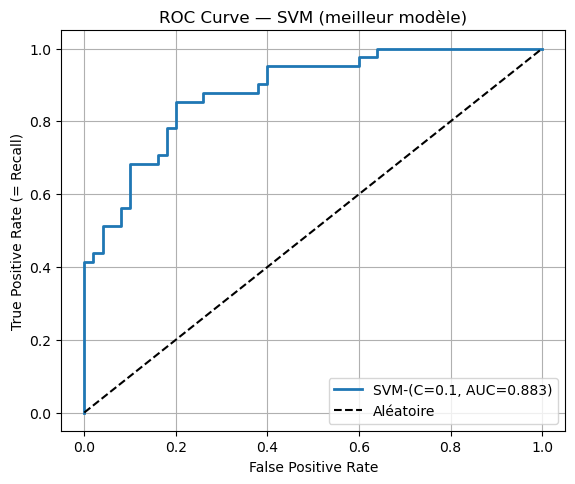

In [ ]:
from sklearn.svm import SVC
#TOFILL
param_gridSVM = [
 {
  'C' : [0.000001,0.00001, 0.0001,0.001,0.01,0.1,1,10,100,1000]}
 ]

modelSVM =  SVC()
modelSVM.fit(X_train_scaled, y_train)

gridSVM = GridSearchCV(
    estimator=modelSVM,
    param_grid=param_gridSVM,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    verbose=10,              
    return_train_score=True
)

gridSVM.fit(X_train_scaled, y_train)

grid_resultsSVM = pd.DataFrame(gridSVM.cv_results_)

# ------------- 1) Résultats du GridSearch en DataFrame propre -------------
cvdfSVM = pd.DataFrame(gridSVM.cv_results_).copy()
# Colonnes d'hyperparamètres (dynamiques)
param_colsSVM = [c for c in cvdfSVM.columns if c.startswith("param_")]

# Métriques lisibles (CV)
cvdfSVM["ROC_AUC_Test"]  = cvdfSVM["mean_test_score"]            # car 'neg_mean_squared_error'
# Ecart-type (approx) de la RMSE via delta method
cvdfSVM["ROC_AUC_std_Test"] = cvdfSVM["std_test_score"].abs()

# (optionnel) si tu avais return_train_score=True
if "mean_train_score" in cvdfSVM:
    cvdfSVM["ROC_AUC_Train"] =cvdfSVM["mean_train_score"]
    cvdfSVM["ROC_AUC_std_Train"] = cvdfSVM["std_train_score"].abs() 
    
# Tableau compact et trié (meilleurs en haut)
tableSVM = cvdfSVM[["rank_test_score","ROC_AUC_Test","ROC_AUC_std_Test","ROC_AUC_Train",'ROC_AUC_std_Train'] + param_colsSVM]
tableSVM = tableSVM.reset_index(drop=True)
tableSVM["DeltaTrainTest"]=(tableSVM.ROC_AUC_Train-tableSVM.ROC_AUC_Test).abs()
tableSVM=tableSVM.sort_values("DeltaTrainTest")
print("Top 10 configurations (CV):")
display(tableSVM.head(10))   # ou print(table.head(10).to_string(index=False))
best_treeSVM = gridSVM.best_estimator_
print(best_treeSVM)


# === 3) ROC AUC sur le TEST ===
# utilisation du decision_function pour l'AUC
y_scores_testSVM = gridSVM.decision_function(X_test_scaled)
test_aucSVM = roc_auc_score(y_test, y_scores_testSVM)
print(f"Test ROC AUC (best SVM): {test_aucSVM:.4f}")

# === 4) Courbe ROC sur le TEST ===
fpr, tpr, thr = roc_curve(y_test, y_scores_testSVM)
plt.figure(figsize=(6.5,5.2))
plt.plot(fpr, tpr, label=f"SVM-(C={gridSVM.best_params_['C']}, AUC={test_aucSVM:.3f})", linewidth=2)
plt.plot([0,1],[0,1],'k--', label="Aléatoire")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (= Recall)")
plt.title("ROC Curve — SVM (meilleur modèle)")
plt.grid(True); plt.legend(loc="lower right")
plt.show()



SVMs offer the possibility to express complex combinations of the features, through different *kernels*. See:

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html

https://towardsdatascience.com/understanding-support-vector-machine-part-2-kernel-trick-mercers-theorem-e1e6848c6c4d

Check the available kernels in scikit-learn, and do a grid-search on kernel types and other hyper-parameters of your choice.

In [ ]:
#TOFILL

param_gridSVMBis = [
 {
  'C' : [0.000001,0.00001, 0.0001,0.001,0.01,0.1,1,10,100,1000],
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
 
 ]

modelSVMBis =  SVC()
modelSVMBis.fit(X_train_scaled, y_train)

gridSVMBis = GridSearchCV(
    estimator=modelSVMBis,
    param_grid=param_gridSVMBis,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    verbose=10,              
    return_train_score=True
)

gridSVMBis.fit(X_train_scaled, y_train)

grid_resultsSVMBis = pd.DataFrame(gridSVMBis.cv_results_)

# ------------- 1) Résultats du GridSearch en DataFrame propre -------------
cvdfSVMBis = pd.DataFrame(gridSVMBis.cv_results_).copy()
# Colonnes d'hyperparamètres (dynamiques)
param_colsSVMBis = [c for c in cvdfSVMBis.columns if c.startswith("param_")]

# Métriques lisibles (CV)
cvdfSVMBis["ROC_AUC_Test"]  = cvdfSVMBis["mean_test_score"]            # car 'neg_mean_squared_error'
# Ecart-type (approx) de la RMSE via delta method
cvdfSVMBis["ROC_AUC_std_Test"] = cvdfSVMBis["std_test_score"].abs()

# (optionnel) si tu avais return_train_score=True
if "mean_train_score" in cvdfSVMBis:
    cvdfSVMBis["ROC_AUC_Train"] =cvdfSVMBis["mean_train_score"]
    cvdfSVMBis["ROC_AUC_std_Train"] = cvdfSVMBis["std_train_score"].abs() 
    
# Tableau compact et trié (meilleurs en haut)
tableSVMBis = cvdfSVMBis[["rank_test_score","ROC_AUC_Test","ROC_AUC_std_Test","ROC_AUC_Train",'ROC_AUC_std_Train'] + param_colsSVMBis]
tableSVMBis = tableSVMBis.reset_index(drop=True)
tableSVMBis["DeltaTrainTest"]=(tableSVMBis.ROC_AUC_Train-tableSVMBis.ROC_AUC_Test).abs()
tableSVMBis=tableSVMBis.sort_values("DeltaTrainTest")
print("Top 10 configurations (CV):")
display(tableSVMBis.head(10))  


# ou print(table.head(10).to_string(index=False))
best_treeSVMBis = gridSVMBis.best_estimator_
print(best_treeSVMBis)



Fitting 10 folds for each of 40 candidates, totalling 400 fits
Top 10 configurations (CV):


,rank_test_score,ROC_AUC_Test,ROC_AUC_std_Test,ROC_AUC_Train,ROC_AUC_std_Train,param_C,param_kernel,DeltaTrainTest
23,5,0.914613,0.037394,0.917734,0.004153,0.100000,sigmoid,0.003121
15,13,0.901987,0.047422,0.905993,0.004782,0.001000,sigmoid,0.004007
3,13,0.901987,0.047422,0.905993,0.004782,0.000001,sigmoid,0.004007
11,13,0.901987,0.047422,0.905993,0.004782,0.000100,sigmoid,0.004007
7,13,0.901987,0.047422,0.905993,0.004782,0.000010,sigmoid,0.004007
19,13,0.901987,0.047422,0.906060,0.004771,0.010000,sigmoid,0.004073
8,11,0.902003,0.045179,0.909281,0.004899,0.000100,linear,0.007278
12,11,0.902003,0.045179,0.909302,0.004817,0.001000,linear,0.007299
0,18,0.901077,0.047014,0.908594,0.004848,0.000001,linear,0.007517
4,18,0.901077,0.047014,0.908594,0.004848,0.000010,linear,0.007517


SVC(C=0.1, kernel='linear')


Test ROC AUC (best SVMBis): 0.7837


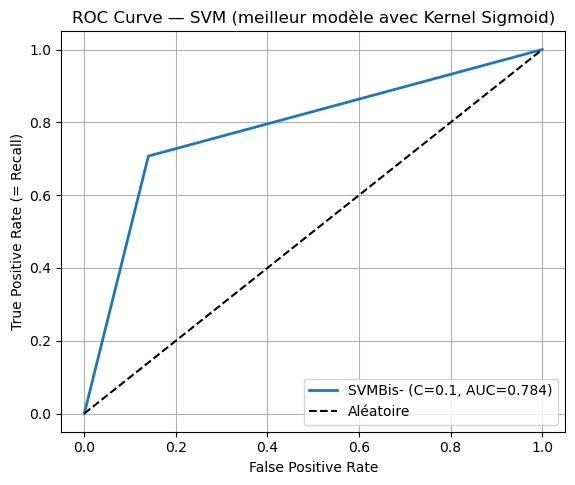

In [ ]:
### toutefois d'après le tableau il est plus judicieux de prendre le kernel=sigmoid et C=0.1, nettement moins d'overfitting
SVMmodel = SVC(kernel='sigmoid',C=0.1, random_state=41) 
SVMmodel.fit(X_train_scaled, y_train)
# === 3) ROC AUC sur le TEST ===
# utilisation du decision_function pour l'AUC
y_scores_testSVMBis=SVMmodel.predict(X_test_scaled)
test_aucSVMBis = roc_auc_score(y_test, y_scores_testSVMBis)
print(f"Test ROC AUC (best SVMBis): {test_aucSVMBis:.4f}")

# === 4) Courbe ROC sur le TEST ===
fpr, tpr, thr = roc_curve(y_test, y_scores_testSVMBis)
plt.figure(figsize=(6.5,5.2))
plt.plot(fpr, tpr, label=f"SVMBis- (C={gridSVMBis.best_params_['C']}, AUC={test_aucSVMBis:.3f})", linewidth=2)
plt.plot([0,1],[0,1],'k--', label="Aléatoire")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (= Recall)")
plt.title("ROC Curve — SVM (meilleur modèle avec Kernel Sigmoid)")
plt.grid(True); plt.legend(loc="lower right")
plt.show()

## Select the best model among all class of models and their hyper-parameters

Write a function that takes a list of different scikit-learn classifiers, as well as a list of each parameter grid to be searched over each classifier, and a scoring function ; and returns the best classifier along with its best parameters and its score. Finally, test it with KNN, SVM and DecisionTrees, and ensure you get a result that is consistent with the results previously obtained. You can also test with LogisticRegression, another powerful classification model.

In [ ]:
def select_best_model_overall(classifiers_list, param_grids_list, X, y, cv=10, scoring='roc_auc',n_jobs=-1, verbose=0):
    """
    Teste plusieurs classifieurs avec leurs grilles d'hyperparamètres via GridSearchCV,
    et renvoie le meilleur modèle selon la métrique 'scoring'.
    
    Parameters
    ----------
    classifiers_list : list
        Liste des estimateurs sklearn (non fit).
    param_grids_list : list
        Liste des dicts de grilles d'hyperparamètres (même ordre que classifiers_list).
    X, y : array-like / DataFrame, Series
        Données et étiquettes.
    cv : int
        Nombre de folds pour la CV (StratifiedKFold).
    scoring : str
        Métrique sklearn (ex: 'roc_auc', 'accuracy', 'average_precision', ...).
    n_jobs : int
        Parallélisation pour GridSearchCV.
    verbose : int
        Verbosité GridSearchCV.
        
    Returns
    -------
    best_classifier : estimator
        Le meilleur estimateur refitté sur tout X,y.
    best_parameters : dict
        Les meilleurs hyperparamètres.
    best_score : float
        Le meilleur score moyen de CV.
    """
    assert len(classifiers_list) == len(param_grids_list), "classifiers_list et param_grids_list doivent avoir la même longueur."
    
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=41)
    
    best_score = -float('inf')
    best_classifier = None
    best_parameters = None
    
    for clf, param_grid in zip(classifiers_list, param_grids_list):
        gs = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            scoring=scoring,
            cv=cv_splitter,
            n_jobs=n_jobs,
            refit=True,          # refit sur tout le train avec les meilleurs params
            verbose=verbose,
            return_train_score=False
        )
        gs.fit(X, y)
        
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_classifier = gs.best_estimator_
            best_parameters = gs.best_params_
    
    return best_classifier, best_parameters, best_score

In [ ]:
classifiers = [
    KNeighborsClassifier(),                       # KNN
    SVC(gamma="scale"),  # SVM RBF (decision_function OK pour AUC)
    DecisionTreeClassifier()       # Arbre
]

param_grids = [
    # --- KNN ---
    {
        "n_neighbors": list(range(1, 101)),
        "weights": ["uniform", "distance"]
    },
    # --- SVM ---
    {
        "C": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "gamma": ["scale", "auto"]
    },
    # --- Decision Tree ---
    {
        "max_depth": list(range(3, 70)),
        "max_leaf_nodes": list(range(2, 20)),
        "min_samples_split": [2, 5, 10], 
        "min_samples_leaf": [1, 2, 4]
    }
]

best_est, best_params, best_cv = select_best_model_overall(
    classifiers, param_grids, X_train_scaled, y_train,
    cv=10, scoring='roc_auc', n_jobs=-1, verbose=10
)

print("=== BEST OVERALL ===")
print(best_est)
print("Best params:", best_params)
print(f"Best mean CV ({'roc_auc'}): {best_cv:.4f}")

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 80 candidates, totalling 800 fits
Fitting 10 folds for each of 10854 candidates, totalling 108540 fits
=== BEST OVERALL ===
SVC(C=10, gamma='auto', kernel='sigmoid')
Best params: {'C': 10, 'gamma': 'auto', 'kernel': 'sigmoid'}
Best mean CV (roc_auc): 0.9264


Test ROC AUC (best SVMBis): 0.8202


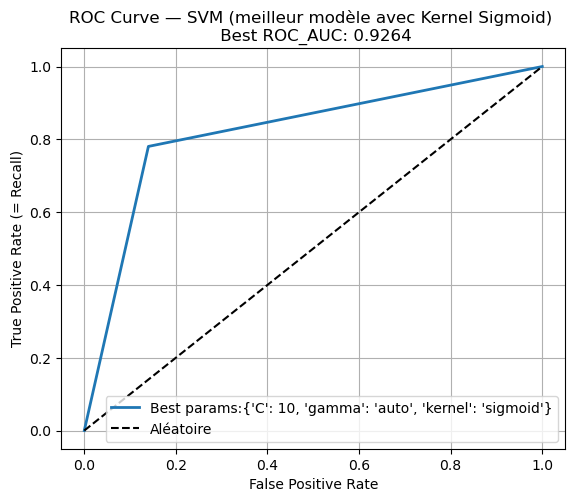

In [ ]:
BestModel = SVC(kernel='sigmoid',C=10, gamma='auto') 
BestModel.fit(X_train_scaled, y_train)
# === 3) ROC AUC sur le TEST ===
# utilisation du decision_function pour l'AUC
y_scores_BestModel=BestModel.predict(X_test_scaled)
test_aucBestModel = roc_auc_score(y_test, y_scores_BestModel)
print(f"Test ROC AUC (best SVMBis): {test_aucBestModel:.4f}")

# === 4) Courbe ROC sur le TEST ===
fpr, tpr, thr = roc_curve(y_test, y_scores_BestModel)
plt.figure(figsize=(6.5,5.2))
plt.plot(fpr, tpr, label=f"Best params:{best_params}", linewidth=2)
plt.plot([0,1],[0,1],'k--', label="Aléatoire")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (= Recall)")
plt.title(f"ROC Curve — SVM (meilleur modèle avec Kernel Sigmoid) \n Best ROC_AUC: {best_cv:.4f}")
plt.grid(True); plt.legend(loc="lower right")
plt.show()